In [ ]:
#Load the needed libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
import torchvision.transforms as transforms
import torch.optim as optim
import os
import shutil
torch.cuda.empty_cache()


In [ ]:
# Connect to gpu
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
#pre-processing the train dataset to load into ImageFolder

train_dir='/content/drive/MyDrive/Meat Freshness.v1-new-dataset.multiclass/train'
test_dir='/content/drive/MyDrive/Meat Freshness.v1-new-dataset.multiclass/valid'
os.mkdir('train')
os.mkdir('train/0') #fresh
os.mkdir('train/1') #Half
os.mkdir('train/2') #Spoilt
#train
for i in os.listdir(train_dir):
  old_path=os.path.join(train_dir, i)
  tag=i.split('-')[0]
  if tag=='FRESH':
    new_path=os.path.join('train/0', i)
    shutil.copyfile(old_path, new_path)
  elif tag=='HALF':
    new_path=os.path.join('train/1', i)
    shutil.copyfile(old_path, new_path)
  elif tag=='SPOILED':
    new_path=os.path.join('train/2', i)
    shutil.copyfile(old_path, new_path)


    

  


In [ ]:
#pre-processing the test dataset to load into ImageFolder
os.mkdir('test')
os.mkdir('test/0') #fresh
os.mkdir('test/1') #Half
os.mkdir('test/2') #Spoilt
for i in os.listdir(test_dir):
  old_path=os.path.join(test_dir, i)
  tag=i.split('-')[0]
  if tag=='FRESH':
    new_path=os.path.join('test/0', i)
    shutil.copyfile(old_path, new_path)
  elif tag=='HALF':
    new_path=os.path.join('test/1', i)
    shutil.copyfile(old_path, new_path)
  elif tag=='SPOILED':
    new_path=os.path.join('test/2', i)
    shutil.copyfile(old_path, new_path)


In [ ]:
transform=transforms.Compose( [transforms.ToTensor(), transforms.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) ), transforms.Resize((25, 25)) ] ) #Data Augmentation

# Load train and test data to the ImageFolder
train_dataset = torchvision.datasets.ImageFolder('/content/train', transform)
val_dataset = torchvision.datasets.ImageFolder('/content/test',  transform)

batch_size = 15

#Load ImageFolder objects to dataloader
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True)



In [ ]:
# Model Architecture
class Net(nn.Module):
  def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 64, kernel_size = 3),
            nn.ReLU(),
            


            nn.Flatten(),
            nn.Linear(4096,64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128,3)
            

        )
    
  def forward(self, xb):
        return self.network(xb)

model = Net().to(device)

In [ ]:
# Loss and Optimizer
criterion=nn.CrossEntropyLoss()
opt=optim.Adam(model.parameters(), lr=0.01)


# **EDA**

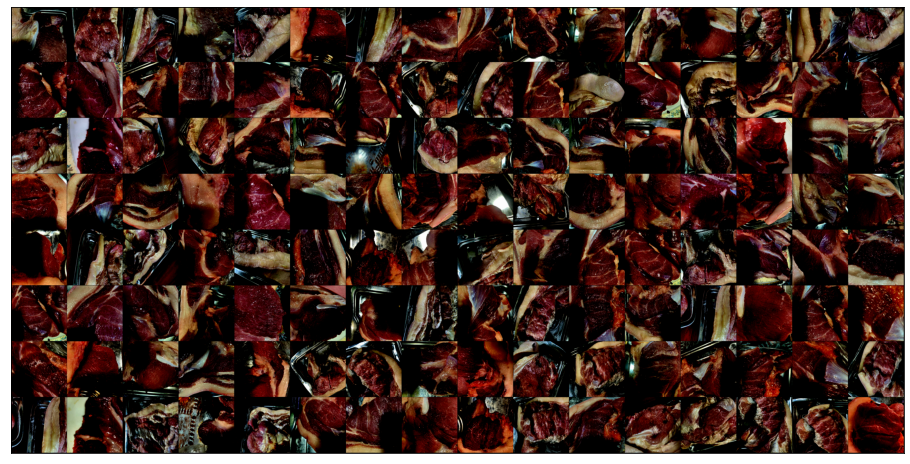

In [ ]:
#View a batch of image from the train dataset
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dataloader)

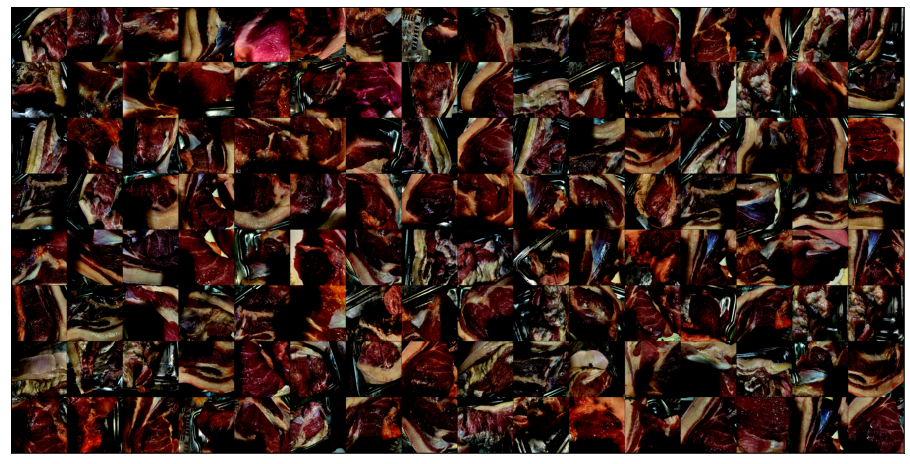

In [ ]:
#View a batch of image from the test 
show_batch(val_dataloader)

In [ ]:
# Number of samples in training and test 
te=str( len(os.listdir(test_dir))  )  
tr=str( len(os.listdir(train_dir))  ) 
print ('The training class contains ' + tr + ' Image samples' )
print ('The training class contains ' + te + ' Image samples' )

The training class contains 1816 Image samples
The training class contains 452 Image samples


In [ ]:
train_1=len(os.listdir('train/0'))
train_2=len(os.listdir('train/1'))
train_3=len(os.listdir('train/2'))

import numpy as np
x=np.array(['FRESH','HALF-FRESH', 'SPOILT'])
y=np.array([train_1, train_2, train_3])

Text(0.5, 1.0, 'Train Dataset Count')

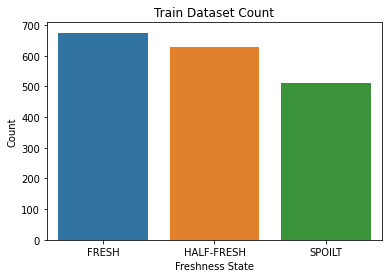

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt
sns.barplot(x= x, y= y)
plt.xlabel ('Freshness State')
plt.ylabel('Count')
plt.title ("Train Dataset Count")

In [ ]:
test_1=len(os.listdir('test/0'))
test_2=len(os.listdir('test/1'))
test_3=len(os.listdir('test/2'))

import numpy as np
x=np.array(['FRESH','HALF-FRESH', 'SPOILT'])
y=np.array([test_1, test_2, test_3])

Text(0.5, 1.0, 'Test Dataset Count')

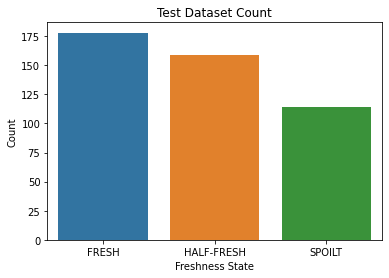

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt
sns.barplot(x= x, y= y)
plt.xlabel ('Freshness State')
plt.ylabel('Count')
plt.title ("Test Dataset Count")

# **Training**

In [ ]:
epochs=50
for epoch in range(epochs):
  running_loss=0
  val_loss=0
  for batch_idx, (data, targets) in enumerate(train_dataloader):
    X_train=data.to(device)
    y_train=targets.to(device)
    outputs=model(X_train)
    loss= criterion(outputs, y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()
    running_loss+= loss.item()
  train_loss=str(epoch+1) + ' Loss: ' + str(running_loss/ len(train_dataloader))
  for batch_idx, (X_test, y_test) in enumerate(val_dataloader) :
    X_test=X_test.to(device)
    y_test=y_test.to(device)
    pred=model(X_test)
    loss= criterion(pred, y_test)
    val_loss+= loss.item()
  validation_loss= ' Val_Loss: ' + str(val_loss/len(val_dataloader))
  print (train_loss, validation_loss)




    


1 Loss: 0.8597333647988059  Val_Loss: 0.7642975987926606
2 Loss: 0.7067437373902187  Val_Loss: 0.7930895926490906
3 Loss: 0.6864546527547285  Val_Loss: 0.7434979263813265
5 Loss: 0.634933383257921  Val_Loss: 0.7129131411352465
6 Loss: 0.6329113488847559  Val_Loss: 0.5877049253772824
7 Loss: 0.5883169903242884  Val_Loss: 0.7147689711663031
8 Loss: 0.6510077783884096  Val_Loss: 0.9454539245174777
9 Loss: 0.5541864578142639  Val_Loss: 0.6920591035196858
10 Loss: 0.6244909364329881  Val_Loss: 0.7232274797654921
11 Loss: 0.5285515492120065  Val_Loss: 0.7142963986242971
12 Loss: 0.5164906004489946  Val_Loss: 0.8198578069286961
13 Loss: 0.5144952033176895  Val_Loss: 0.6768750548362732
14 Loss: 0.8309727642408087  Val_Loss: 0.8782906887992736
15 Loss: 0.6754678187291484  Val_Loss: 0.8820391422317874
16 Loss: 0.5933078629665138  Val_Loss: 0.7074042116442034
17 Loss: 0.5659078081284673  Val_Loss: 0.677859553886998
18 Loss: 0.5385795284893887  Val_Loss: 0.635278279742887
19 Loss: 0.54122292047197

In [ ]:
test_acc=0
model.eval()
  
with torch.no_grad():
    #Iterating over the training dataset in batches
    for i, (images, labels) in enumerate(val_dataloader):
          
        images = images.to(device)
        y_true = labels.to(device)
          
        #Calculating outputs for the batch being iterated
        outputs = model(images)
          
        #Calculated prediction labels from models
        _, y_pred = torch.max(outputs.data, 1)
          
        #Comparing predicted and true labels
        test_acc += (y_pred == y_true).sum().item()
      
    print(f"Test set accuracy = {100 * test_acc /452} %")

Test set accuracy = 75.88495575221239 %


In [ ]:
train_acc=0
model.eval()
  
with torch.no_grad():
    #Iterating over the training dataset in batches
    for i, (images, labels) in enumerate(train_dataloader):
          
        images = images.to(device)
        y_true = labels.to(device)
          
        #Calculating outputs for the batch being iterated
        outputs = model(images)
          
        #Calculated prediction labels from models
        _, y_pred = torch.max(outputs.data, 1)
          
        #Comparing predicted and true labels
        train_acc += (y_pred == y_true).sum().item()
      
    print(f"Test set accuracy = {100 * train_acc / 1816} %")

Test set accuracy = 86.1784140969163 %


Saving the Model

In [ ]:
import PIL

In [ ]:
#torch.save(model, 'model.pth')
#mod = torch.load('model.pth')

In [ ]:
mod = torch.load('model.pth')

In [ ]:
img_path= '/content/train/2/SPOILED-1008-_JPG.rf.51acdf3d5ccb48a46aafe8786859e0a2.jpg'
image = PIL.Image.open(img_path)
transform=transforms.Compose( [transforms.ToTensor(), transforms.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) ), transforms.Resize((25, 25)) ] )
image = transform(image).unsqueeze(0)


In [ ]:
mod = mod.cpu()
mod.eval()
pred = torch.argmax(mod(image))
pred=pred.item()
if pred==0:
  print('This meat is predicted to be Fresh')
elif pred==1:
  print('This meat is predicted to be HALF-FRESH')
elif pred== 2:
  print('This meat is predicted to be SPOILT')


This meat is predicted to be SPOILT
